In [41]:
import os
import random
from collections import Counter

import cv2
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

from dask import bag, diagnostics
import hvplot.pandas

%matplotlib inline

# Read training annotation

Training annotation stored in `cars_train_annos.mat`, so we will use `scipy` library to read the matrix

In [13]:
train_annotation = loadmat("data/devkit/cars_train_annos.mat")

From the matrix loaded, classes and image file path can be gotten

In [31]:
classes = [c[0][0] for c in train_annotation['annotations'][0]['class']]
fnames = [str(fname[0]) for fname in train_annotation['annotations'][0]['fname']]

The same goes for `cars_meta.mat`, we will load the class meta data:

In [32]:
class_metas = loadmat("data/devkit/cars_meta.mat")
class_metas = class_metas['class_names']
class_metas = [str(c[0]) for c in class_metas[0]]

# Images

Let's plot some random images from the dataset to see the complex of the problem

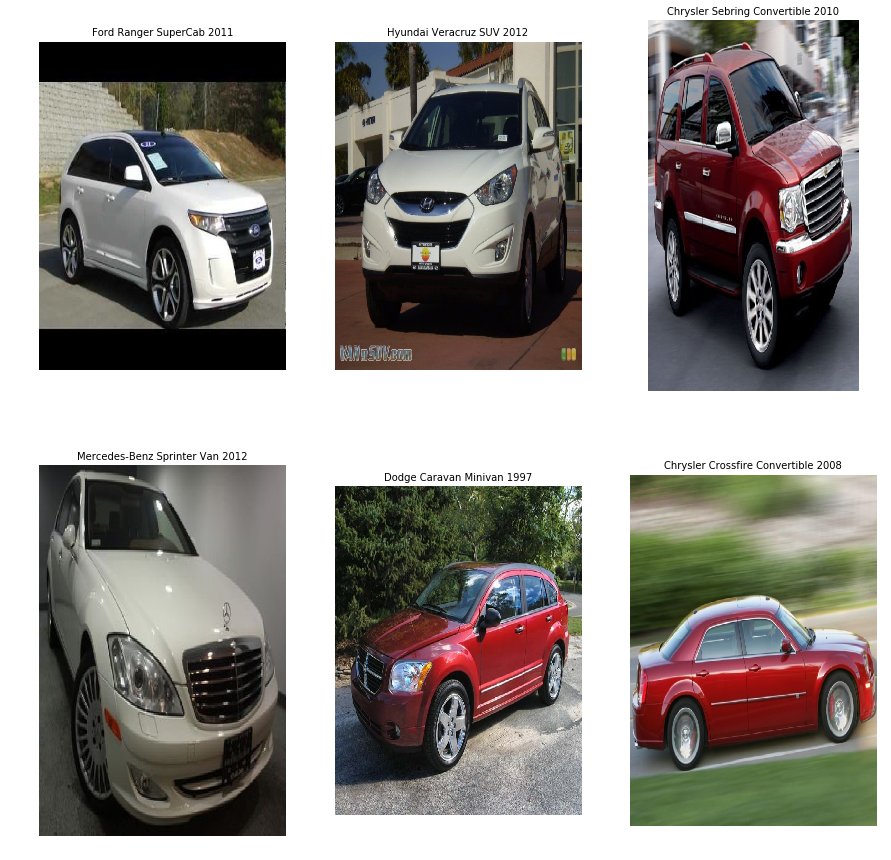

In [33]:
fig, ax = plt.subplots() 
fig.set_size_inches((15,15))
ax.set_axis_off()

selected_indices = random.choices(range(len(fnames)), k=6)
for n, index in enumerate(selected_indices):
    
    a = fig.add_subplot(2, 3, n + 1)
    
    fname = fnames[index]
    
    class_name = class_metas[classes[index]]
    
    img = cv2.imread(os.path.join("data/cars_train", fname), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h0, w0 = img.shape[:2]
    scale = 1024/max(h0, w0)
    h, w = int(round(h0*scale)), int(round(w0*scale))
    img = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)
    plt.title(class_name, fontsize=10)
    plt.axis('off')
    plt.imshow(img)

As can be observed, cars are captured with different angles. In some of them, people can see the logo clearly, the rest cannot be. The task becomes more complicated when we need to classify Make and Model of each car.

The images are clearly of different dimensions. We can use the test images to explore since they're already in the container. I'll use Dask to parallelize the operation and speed things up.

In [42]:
# get image dimensions
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

# parallelize
filepath = 'data/cars_train/'
filelist = [filepath + f for f in os.listdir(filepath) if not f.startswith(".")]
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

[########################################] | 100% Completed | 14.1s


:Scatter   [height]   (width,count)

Images have various sizes, we need to resize it before feeding to the network

# Labels distribution

Using `Counter`, we get the distribution of labels:

In [10]:
counter = Counter(classes)

Get top three most common classes:

In [11]:
counter.most_common(3)

[(119, 68), (79, 49), (167, 48)]

Using `matplotlib` to visualize the histogram of distribution

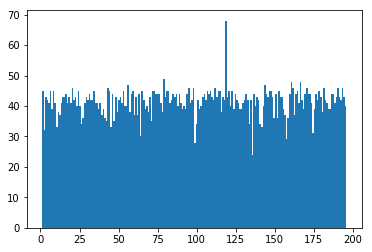

In [9]:
_ = plt.hist(classes, bins=196)

As can be observed, the class **119** appears 68 times while the others account for around 45 in the whole dataset. This class can affect the model, we can apply **oversampling** for this dataset during training.